# Punctuation prediction using BLSTM model on top of BERT model!

## Installing requirements (please install [pytorch](https://pytorch.org/get-started/locally/) compatible with your cuda version before)

In [ ]:
!pip install numpy
!pip install pandas
!pip install transformers
!pip install tqdm
!pip install simpletransformers

## Check your cuda and gpu

In [1]:
!nvidia-smi

Thu Dec 29 00:40:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0  On |                  N/A |
| 30%   37C    P8    32W / 350W |    970MiB / 24245MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Model architecture definition

In [2]:
from simpletransformers.ner import NERModel, NERArgs
import numpy as np
import pandas as pd
from transformers import BertModel
from torch import nn
from tqdm.auto import tqdm, trange
from torch.optim import Adam, SGD
import torch
from torch.utils.data import DataLoader, TensorDataset


class BertOnBLSTM(nn.Module):
    def __init__(self, bert_dim, output_dim, num_layers, rnn_dim):
        super(BertOnBLSTM, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.rnn = nn.LSTM(bert_dim, rnn_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(rnn_dim*2, output_dim)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, x, y, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        loss = self.loss_function(output, y)
        return loss

    def test(self, x, y, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        loss = self.loss_function(output, y)
        predict = self.predict_label(output.transpose(1, 2), mask)
        return loss, predict

    def predict(self, x, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        return output.transpose(1, 2).argmax(2)

    def predict_label(self, output, mask):
        """
        output: batch_size, max_sentence_len, tag_num
        mask: same label data
        batch_label: batch_size, sentence_label
        """
        pre_label = []
        pre_label_pad = output.argmax(2)
        for i in range(mask.shape[0]):
            sent_label = []
            for j in range(mask.shape[1]):
                if mask[i, j] == 1:
                    sent_label.append(pre_label_pad[i, j].item())
            sent_label = sent_label[1:len(sent_label)-1]
            pre_label.append(sent_label)

        return pre_label


In [3]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]

## Note: For this model, we import a ner model just to use its advantages in loading the data. And you can see we have set: `use_cuda=False`

In [4]:
model_args = NERArgs()
model_args.overwrite_output_dir = True
model_args.save_steps = -1
ner_model = NERModel('bert',
                 'bert-base-uncased',
                 labels = labels_set,
                 args=model_args,
                 use_cuda=False)
ner_model.args.max_seq_length = 512

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

## Training bins 1 to 9. 

In [5]:
bert_dim = 768
output_dim = len(labels_set)
batch_size = 32
adam_lr = 3e-5
epoch = 1
num_layers = 1
rnn_dim = 512
model = BertOnBLSTM(bert_dim, output_dim, num_layers, rnn_dim)

def train(model, tr_ds, val_ds):
    use_gpu = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_gpu else 'cpu')
    train_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=False)
    validation_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    
    
    if use_gpu:
        model.to(device)
    optimizer = Adam(model.parameters(), lr=adam_lr)
    for i in range(epoch):
        epoch_loss = 0
        batch_iterator = tqdm(train_dataloader, desc=f"Running Epoch {i+1} of {epoch}", mininterval=0)
        
        for (j, batch) in enumerate(batch_iterator):
            batch_x = batch[0].to(device)
            batch_y = batch[3].to(device)
            batch_seg = batch[2].to(device)
            batch_msk = batch[1].to(device)
            loss = model(batch_x, batch_y, batch_seg, batch_msk)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        dev_loss = 0
        predict_idx_label = []

        for (h, val_batch) in enumerate(validation_dataloader):
            val_batch_x = val_batch[0].to(device)
            val_batch_y = val_batch[3].to(device)
            val_batch_seg = val_batch[2].to(device)
            val_batch_msk = val_batch[1].to(device)
            with torch.no_grad():
                loss_val, pre_y = model.test(val_batch_x, val_batch_y, val_batch_seg, val_batch_msk)
            dev_loss += loss_val.item()            
            predict_idx_label.append(pre_y)
        print(f"Epoch {i+1}/{epoch}:\n\tTraining Loss: \t\t{epoch_loss/(j+1):9.4f}\n\tValidation Loss: \t{dev_loss/(h+1):9.4f}")
        print('*******************************************************')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
validation_df = pd.read_csv('./preprocessed_wikitext/validation.csv').dropna()
validation_dataset = ner_model.load_and_cache_examples(validation_df)
for i in range(9):
    print(f"Dataset: {i}")
    train_df = pd.read_csv(f'./preprocessed_wikitext/train{i}-10.csv').dropna()
    train_dataset = ner_model.load_and_cache_examples(train_df)
    train(model, train_dataset, validation_dataset)
    torch.save(model.state_dict(), f"./bert_on_blstm_models/{i}/blstm_on_bert_model.ckpt")

  0%|          | 0/4 [00:00<?, ?it/s]

Dataset: 0


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2677 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.1285
	Validation Loss: 	   0.0829
*******************************************************
Dataset: 1


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2714 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0855
	Validation Loss: 	   0.0764
*******************************************************
Dataset: 2


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2713 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0808
	Validation Loss: 	   0.0733
*******************************************************
Dataset: 3


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2704 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0779
	Validation Loss: 	   0.0713
*******************************************************
Dataset: 4


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2693 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0764
	Validation Loss: 	   0.0699
*******************************************************
Dataset: 5


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2695 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0757
	Validation Loss: 	   0.0680
*******************************************************
Dataset: 6


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2726 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0743
	Validation Loss: 	   0.0698
*******************************************************
Dataset: 7


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2696 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0743
	Validation Loss: 	   0.0678
*******************************************************
Dataset: 8


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2701 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0732
	Validation Loss: 	   0.0683
*******************************************************


## Testing on the last bin of the dataset

In [7]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from simpletransformers.ner.ner_utils import InputExample

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def flatten_chunk(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def test_model(to_predict, predictor_model, ner_model):
    predict_examples = [InputExample(i,sentence.split(),[ner_model.args.labels_list[0] for word in sentence.lower().split()],) for i, sentence in enumerate(to_predict)]
    eval_dataset = ner_model.load_and_cache_examples(None, evaluate=True, no_cache=True, to_predict=predict_examples)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=batch_size)
    
    batch_to_predict = list(chunks(to_predict, batch_size))
    eval_batch_iterator = tqdm(eval_dataloader, desc=f"Testing!", mininterval=0)
    use_gpu = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_gpu else 'cpu')
    model.to(device)
    final_preds = []
    for (j, val_batch) in enumerate(eval_batch_iterator):
        val_batch_x = val_batch[0].to(device)
        val_batch_y = val_batch[3].to(device)
        val_batch_seg = val_batch[2].to(device)
        val_batch_msk = val_batch[1].to(device)
        with torch.no_grad():
            pre_y = predictor_model.predict(val_batch_x, val_batch_seg, val_batch_msk)
        out_label_ids = [[] for _ in range(len(val_batch_x))]

        max_len = np.max([len(x) for x in val_batch_x])
        for index, sentence in enumerate(batch_to_predict[j]):
            for word in sentence.split():
                word_tokens = ner_model.tokenizer.tokenize(word)
                out_label_ids[index].extend([0] + [-100] * (len(word_tokens) - 1))
            out_label_ids[index].insert(0, -100)
            out_label_ids[index].append(-100)
            if len(out_label_ids[index]) < max_len:
                out_label_ids[index].extend([-100] * (max_len - len(out_label_ids[index])))
        xfer_label_ids = np.zeros((len(out_label_ids), max_len))
        for i, out_label_id in enumerate(out_label_ids):
            for j, label in enumerate(out_label_id):
                xfer_label_ids[i][j] = np.int32(label)
        out_label_ids = np.array([list(x) for x in out_label_ids], np.int32)
        preds = pre_y.to("cpu")
        label_map = {i: label for i, label in enumerate(labels_set)}
        out_label_list = [[] for _ in range(out_label_ids.shape[0])]
        preds_list = [[] for _ in range(out_label_ids.shape[0])]
        for i in range(out_label_ids.shape[0]):
            for j in range(out_label_ids.shape[1]):
                if out_label_ids[i, j] != -100:
                    out_label_list[i].append(label_map[out_label_ids[i][j]])
                    preds_list[i].append(label_map[preds[i][j].item()])
        final_preds.append(preds_list)
    return flatten_chunk(final_preds)

In [8]:
import pandas as pd

testdf = pd.read_csv('./preprocessed_wikitext/train9-10.csv').dropna()

In [9]:
groups = [df for _, df in testdf.groupby('sentence_id')]

In [10]:
to_predicts = []
true_labels = []
for i, sentence in enumerate(groups):
    to_predicts.append(' '.join(sentence['words'].to_list()))
    true_labels.append(sentence['labels'].to_list())

In [11]:
preds_list = test_model(to_predict=to_predicts, predictor_model=model, ner_model=ner_model)

  0%|          | 0/45 [00:00<?, ?it/s]

Testing!:   0%|          | 0/2714 [00:00<?, ?it/s]

In [12]:
for i in range(len(preds_list)):
    if(len(preds_list[i]) != len(true_labels[i])):
        print('THIS IS NOT GOOD', i)

## Evaluation

In [13]:
import itertools
ps = list(itertools.chain.from_iterable(preds_list))
ts = list(itertools.chain.from_iterable(true_labels))

### Normalizing the confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=ts,y_pred=ps, labels=labels_set)
cm

array([[ 376158,    3062,       8,       3,     545,    1722,  115200],
       [   1600,  335031,     124,      13,     426,     123,   21036],
       [     33,     114,     560,       2,       1,       0,     367],
       [     64,     395,      19,      59,      11,       0,     955],
       [   3515,    1192,       4,       2,    6985,     852,    4501],
       [   5253,    1690,       1,       1,     196,    9407,    2186],
       [  73411,   12163,      52,      11,    1039,     418, 8053598]])

In [15]:
import numpy as np
summ = np.sum(cm, axis=1)
summ = np.expand_dims(summ, axis=1)

In [16]:
nor_cm = (cm/summ)
nor_cm

array([[7.57317324e-01, 6.16471176e-03, 1.61063664e-05, 6.03988742e-06,
        1.09724621e-03, 3.46689538e-03, 2.31931677e-01],
       [4.46487123e-03, 9.34918921e-01, 3.46027520e-04, 3.62770787e-05,
        1.18877197e-03, 3.43236976e-04, 5.87018945e-02],
       [3.06406685e-02, 1.05849582e-01, 5.19962860e-01, 1.85701021e-03,
        9.28505107e-04, 0.00000000e+00, 3.40761374e-01],
       [4.25815037e-02, 2.62807718e-01, 1.26413839e-02, 3.92548237e-02,
        7.31869594e-03, 0.00000000e+00, 6.35395875e-01],
       [2.06146267e-01, 6.99079233e-02, 2.34590347e-04, 1.17295173e-04,
        4.09653393e-01, 4.99677438e-02, 2.63972788e-01],
       [2.80399274e-01, 9.02103128e-02, 5.33788833e-05, 5.33788833e-05,
        1.04622611e-02, 5.02135155e-01, 1.16686239e-01],
       [9.01778375e-03, 1.49409903e-03, 6.38766336e-06, 1.35123648e-06,
        1.27630427e-04, 5.13469862e-05, 9.89301401e-01]])

In [17]:
nor_cm.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

In [18]:
print(classification_report(ts, ps))

              precision    recall  f1-score   support

     I-COLON       0.76      0.41      0.53     17051
     I-COMMA       0.82      0.76      0.79    496698
       I-DOT       0.95      0.93      0.94    358353
     I-EMARK       0.65      0.04      0.07      1503
     I-QMARK       0.73      0.52      0.61      1077
 I-SEMICOLON       0.75      0.50      0.60     18734
           O       0.98      0.99      0.99   8140692

    accuracy                           0.97   9034108
   macro avg       0.81      0.59      0.65   9034108
weighted avg       0.97      0.97      0.97   9034108



Text(114.0, 0.5, 'True Label')

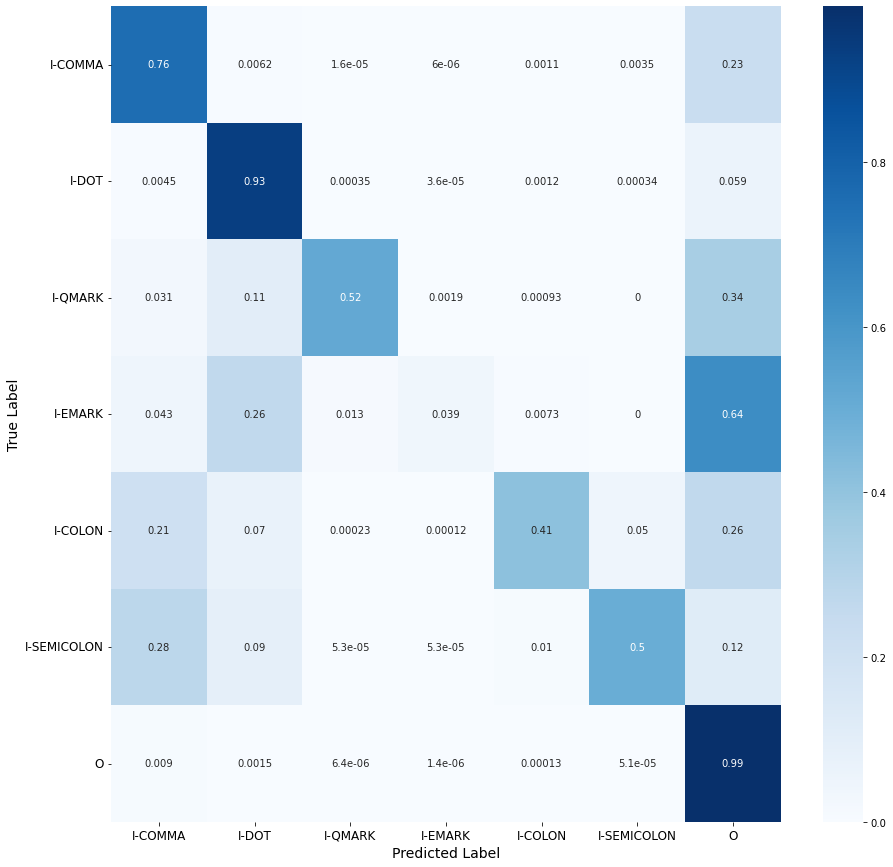

In [19]:
plot_labels = labels_set
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(nor_cm,
            ax=ax, 
            annot=True,
            cmap='Blues',
            xticklabels=plot_labels,
            yticklabels=plot_labels)
plt.yticks(rotation=0,size=12)
plt.xticks(size=12)
ax.set_xlabel('Predicted Label',size=14)
ax.set_ylabel('True Label',size=14)